# Fitness MCMC Documentation Notebook

In [1]:
#Standard Imports
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
#Imports from fitness mcmc package 
import fitness_mcmc
import fitness_mcmc.data_io as io 
import fitness_mcmc.fitness_mcmc as m

## Overview 

Mapping genotypes to phenotypes is critical to uncovering hidden biological functions. Genotypic association studies in model organisms can now explain much of the observed hertiability in many traits thereby allowing us to predict phenotype from genotype. However, large data sizes can confound analyses and so can constrain predicitive power. As a solution, the goal of this package is to distill genotypic data to summary statistics - a set of single quantitative values that would fully represent each lineage (genotype) in an experiment. 

This distillation vies for computational simplicity while aiming to capture the complexities within the original dataset. In more defined terms, we're infering ***fitnesses*** represented by: 

$$ s_{i} = \text{fitnesses} $$ 

from a set of population assays represented by the variable: 

$$ n_{i} = \text{raw counts} $$ 

The $n_{i}$ counts get normalized to the total counts from each lineage for each generation such that 

$$ f_{i} = \text{normalize}(n_{i}) $$ 

The generations are measured in units of how many times the organisms have doubled i.e. if they doubled 7 times in 24 hours then the generation count would be 7. Generational count is incorporated in the model by the value: 

$$ t = \text{generations} $$

The last variable of concern is $f_0$ - the initial frequency of each lineage at generation count equal to zero. We don't actually know the intial frequency count so we would like to infer both this and the fitneseses of each genotype according to the expontential model defined below. 

It should be mentioned that the prior fitness is not flat. A gaussian shape can be assumed and we take hyper priors on it. Therefore, s can be defined as: 

$$s_{i} = \text{Normal}(\mu,\sigma)$$ 

Where $\mu$ and $\sigma$ are hyper-priors. We can marginalize over these parameters later and so understand our uncertainities better given current knowledge. 

## Statistical Model

The generative model to infer fitnesses from genotypes assumes an exponential dependence of fitness on data. The prior we currently assume for fitnesses is assumed to be flat. We actually know that the prior for the fitnesses can follow a normal distribution given hyperpriors defining mu and sigma. This will be implemented in a later version of this package.  

prior: $$s_{i} \sim \text{flat}('fitnesses') $$

The likelihood takes a poisson function since there is noise from the discrete count sampling from generation to generation. However, the model that describes the frequency of each lineage as a function of time, intial frequency and fitness is a normalized exponential (the denominator represents this normalization).

likelihood $$ f_{i} \sim \frac {f_{0_{i}} * exp(s_i * t)} {\sum_{i} f_{0_{i}} * exp(s_i * t)}$$

We're trying to infer from the fitness and initial frequency given this exponential function. 

### Let's look at the data

The function `load_data` in `data_io.py` returns a pandas dataframe of the raw data (i.e. `data`), a numpy array of time generations (i.e. `time`), and a numpy array of arrays of ordered frequencies (i.e. `ordered_frequencies`) where the order is determined by the number of counts. 

In [29]:
"""
Loading data and looking at the first 40 ordered genotypes. 
"""
data, time, ordered_frequencies  = io.load_data('filtered_counts_ypd_temp_30.txt')
data

,BC,5,10,25,40,45
0,GGGAGACCGCCGCGGG_AGACGACGGGTATTAC,1682,1101,416,112,41
1,TTATGAAGTAGTTGTA_AATTTTTTTGCCATTC,463,169,50,3,7
2,ATACAATCATTCATAG_CCCGTGAGCTGAGCCG,1375,322,148,120,36
3,GGGTAATCACGCCGAA_GGCAACTAATAATATA,639,256,151,64,31
4,TAGAACCGGTTAAAAA_TGGTAGCTGGACGACA,917,231,48,5,15
...,...,...,...,...,...,...
718,CCAAACGCCGTACTAT_CGTCTAGCATAAAGCA,231,106,21,2,0
719,ACCGCCTGGTCACCAG_TTCGTTACTGCCGGGG,278,111,9,5,0
720,TACAACGGATTGGGAA_TTCACATCTGGTACCA,833,181,89,43,47
721,ACGCACCAAGCCGGGA_CCGGGCGATCCACGAA,2916,1559,334,98,47


The first row `5, 10, 25, 40, 45` shows the generations where genotypes are sampled. The values under the generation represent counts - the number of each genotype alive. The frequency metadata is calculated by normalizing the counts per generation sample and then they are ordered by genotype with the most total counts across all generations. That is what ordered frequencies represents. 

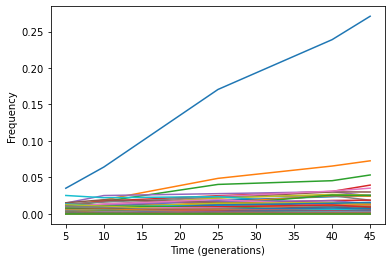

In [4]:
plt.plot([5,10,25,40,45],ordered_frequencies.T);
plt.xlabel('Time (generations)')
plt.ylabel('Frequency')
plt.show()

A visual Plot of the data below. Each line indicates a lineage or a genotype (e.g. a series of CCAAA...). 

## Doing some inference on subset of real data

We take our fitness model object and give it our ordered frequencies, metadata generated earlier, and the time generations. Calling `find_MAP()`, we and then plotting we see how well our reconstructed model compares to the actual data in a linear plot of frequencies vs generations. 

In [7]:
fitness_model = m.Fitness_Model(ordered_frequencies[0:40],time)
fitness_model.find_MAP()

In [ ]:
best_fit, scipy_output = fitness_model.map_estimate
uncertainty = best_fit["sigma"]
best_fit

In [50]:
covariance_matrix = np.flip(scipy_output.hess_inv.todense()/uncertainty)
pd.DataFrame(covariance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,821.492625,-153.795625,68.427734,9.132804,-30.477017,13.759507,-4.981839,45.349609,39.776750,45.071996,...,-359.710080,-1827.590139,-520.898506,-528.586506,-323.237605,-525.949448,-389.148106,-469.076100,-634.025818,-582.270289
1,-153.795625,98.866843,-16.233952,4.819076,-10.299726,-7.603948,4.236471,-11.201608,-15.959338,-9.537194,...,116.678185,275.425686,149.844518,152.108439,107.744617,155.461515,151.136384,144.842461,165.807287,161.600004
2,68.427734,-16.233952,36.956192,0.824407,-5.652978,2.247950,0.064288,1.103350,3.524779,1.044777,...,-36.357613,-86.849364,-48.892607,-50.623766,-34.683361,-54.460633,-54.345578,-49.457612,-55.253861,-55.116322
3,9.132804,4.819076,0.824407,39.423214,-8.413406,-1.571440,1.258364,-0.092114,0.050432,-0.021680,...,3.140871,33.600447,3.047479,1.866836,1.273423,-1.765427,-6.895138,-0.735758,3.572473,0.949206
4,-30.477017,-10.299726,-5.652978,-8.413406,51.598748,4.742450,-3.076010,-2.464384,2.651338,-3.045987,...,-5.933895,13.437836,-2.382256,-0.721017,-3.722827,3.396766,2.563982,0.660628,0.834172,2.050876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-525.949448,155.461515,-54.460633,-1.765427,3.396766,-13.138013,5.584285,-35.850963,-38.306810,-32.754812,...,316.750532,975.535224,424.778287,433.173010,292.792632,480.234555,407.153185,407.238178,485.674916,467.696843
76,-389.148106,151.136384,-54.345578,-6.895138,2.563982,-6.881752,2.210317,-34.003039,-35.047780,-29.363606,...,291.062272,390.450078,367.944885,379.245277,278.197925,407.153185,477.206830,379.227555,395.879880,404.144045
77,-469.076100,144.842461,-49.457612,-0.735758,0.660628,-12.411093,5.454666,-32.583355,-35.644300,-29.526765,...,291.333041,845.797093,387.798829,395.583899,269.890805,407.238178,379.227555,409.219791,440.574848,426.201987
78,-634.025818,165.807287,-55.253861,3.572473,0.834172,-19.041637,8.900370,-37.867489,-42.589251,-35.642312,...,346.729739,1418.636471,479.666094,485.956560,313.689267,485.674916,395.879880,440.574848,600.639823,527.876764


In [189]:
covariance_matrix = np.flip(scipy_output.hess_inv.todense()/uncertainty)
pd.DataFrame(covariance_matrix[0:4,0:4])

,0,1,2,3
0,821.492625,-153.795625,68.427734,9.132804
1,-153.795625,98.866843,-16.233952,4.819076
2,68.427734,-16.233952,36.956192,0.824407
3,9.132804,4.819076,0.824407,39.423214


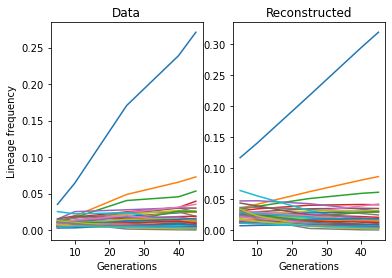

<Figure size 432x288 with 0 Axes>

In [15]:
fitness_model.plot_MAP_estimate(type = "lin")
plt.savefig("data_comparison.png", format = "png", dpi = 300)

## Doing inference on simulated data  

We compare the fitted functions with the simulated data. 

In [7]:
#simulated data 
data, time, ordered_frequencies, s_vals, f0_vals = io.load_data("simulated_data_2.txt", 
                                                                 data_dir = "simulated_data",
                                                                 load_metadata = True)
simulated_model = m.Fitness_Model(ordered_frequencies,time)
true_trajectories = m.create_trajectories(f0_vals, s_vals, [5,10,25,40,45])
simulated_model.find_MAP()


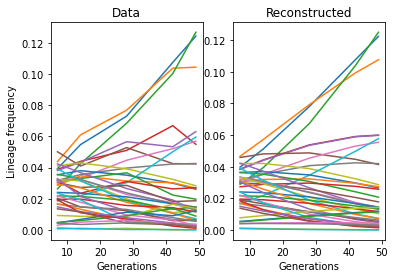

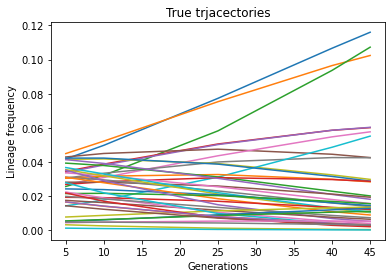

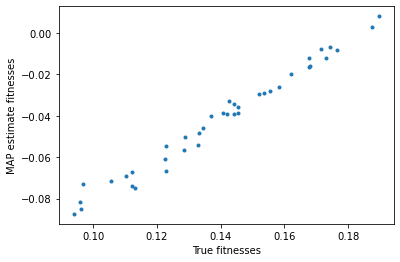

In [8]:
simulated_model.plot_MAP_estimate(type = "lin")
plt.figure()
plt.plot([5,10,25,40,45], true_trajectories.T)
plt.title("True trjacectories")
plt.xlabel("Generations")
plt.ylabel("Lineage frequency")

plt.figure()
plt.plot(s_vals[1:] + s_vals[0], simulated_model.map_estimate["s"], ".")
plt.xlabel("True fitnesses")
plt.ylabel("MAP estimate fitnesses")
plt.show()

## Doing inference with MCMC on real data

Completing MCMC to generate quantitative understanding of the uncerainities on our estimated fitness and intial frequency values. (Using a subset of our real data) 

In [53]:
fitness_model = m.Fitness_Model(ordered_frequencies,time)
fitness_model.mcmc_sample(draws = 2000, tune = 4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f0, s, sigma, mu]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 150 seconds.


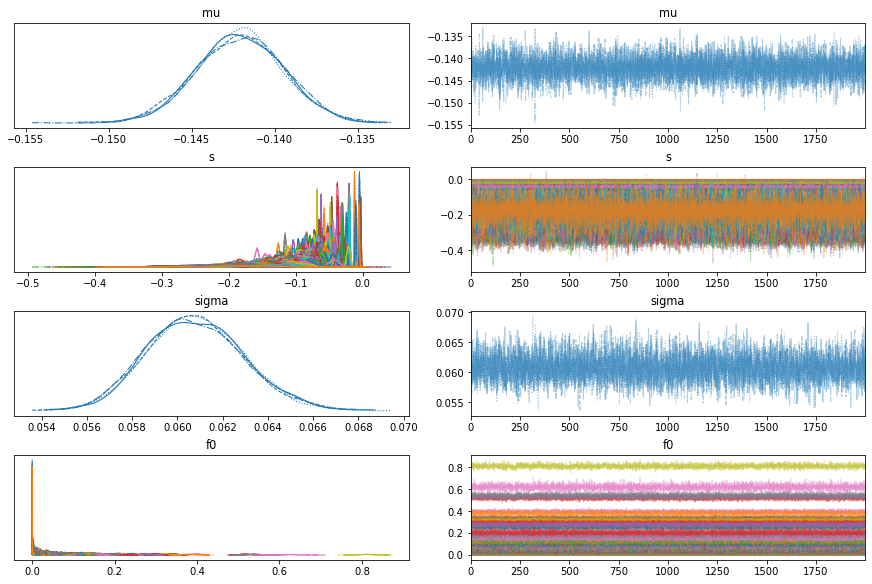

In [54]:
fitness_model.plot_mcmc_trace()

The mcmc trace provides an insight into the distribution of s and $f_{0}$ values. 

In [133]:
df = fitness_model.trace.to_dataframe()

Makes a dataframe of the MCMC. 

In [178]:
df.columns = range(df.shape[1])
df_fitnesses = df.iloc[:,3:724]
df_frequencies = df.iloc[:,726:1447]

RangeIndex(start=0, stop=5076, step=1)


In [194]:
df_fitnesses.columns = ["fitness lineage {}".format(i) for i in range(3,724)]
df_frequencies.columns = ["f0 lineage {}".format(i) for i in range(3,724)]

We look at the first two lineages' parameters and compare them in a seaborn pairplot. 

In [195]:
new_df = pd.concat([df_fitnesses.iloc[:,0:2],df_frequencies.iloc[:,0:2]],axis =1)

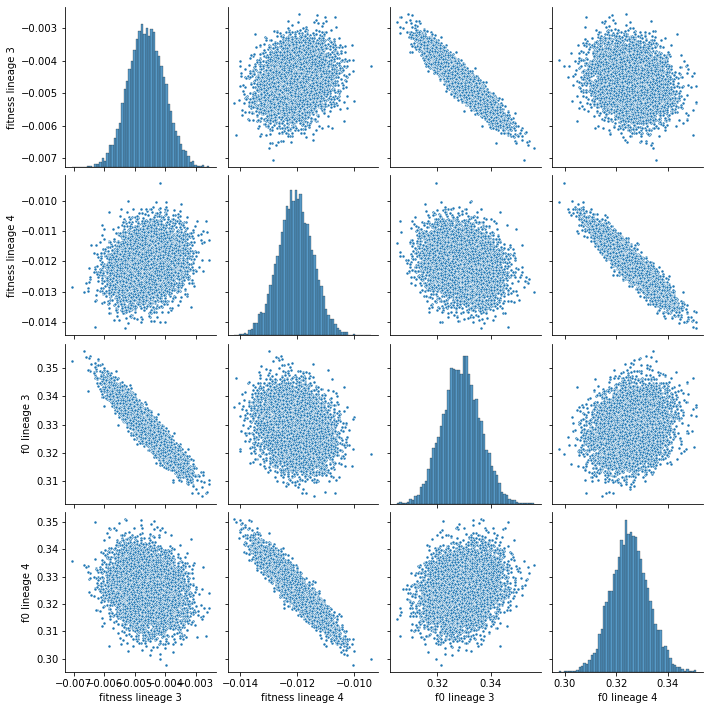

In [196]:
sns.pairplot(new_df, markers='.');

/Users/pavelzhelnin/anaconda3/envs/phys201/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1446) in plot_posterior, generating only 40 plots
  warnings.warn(


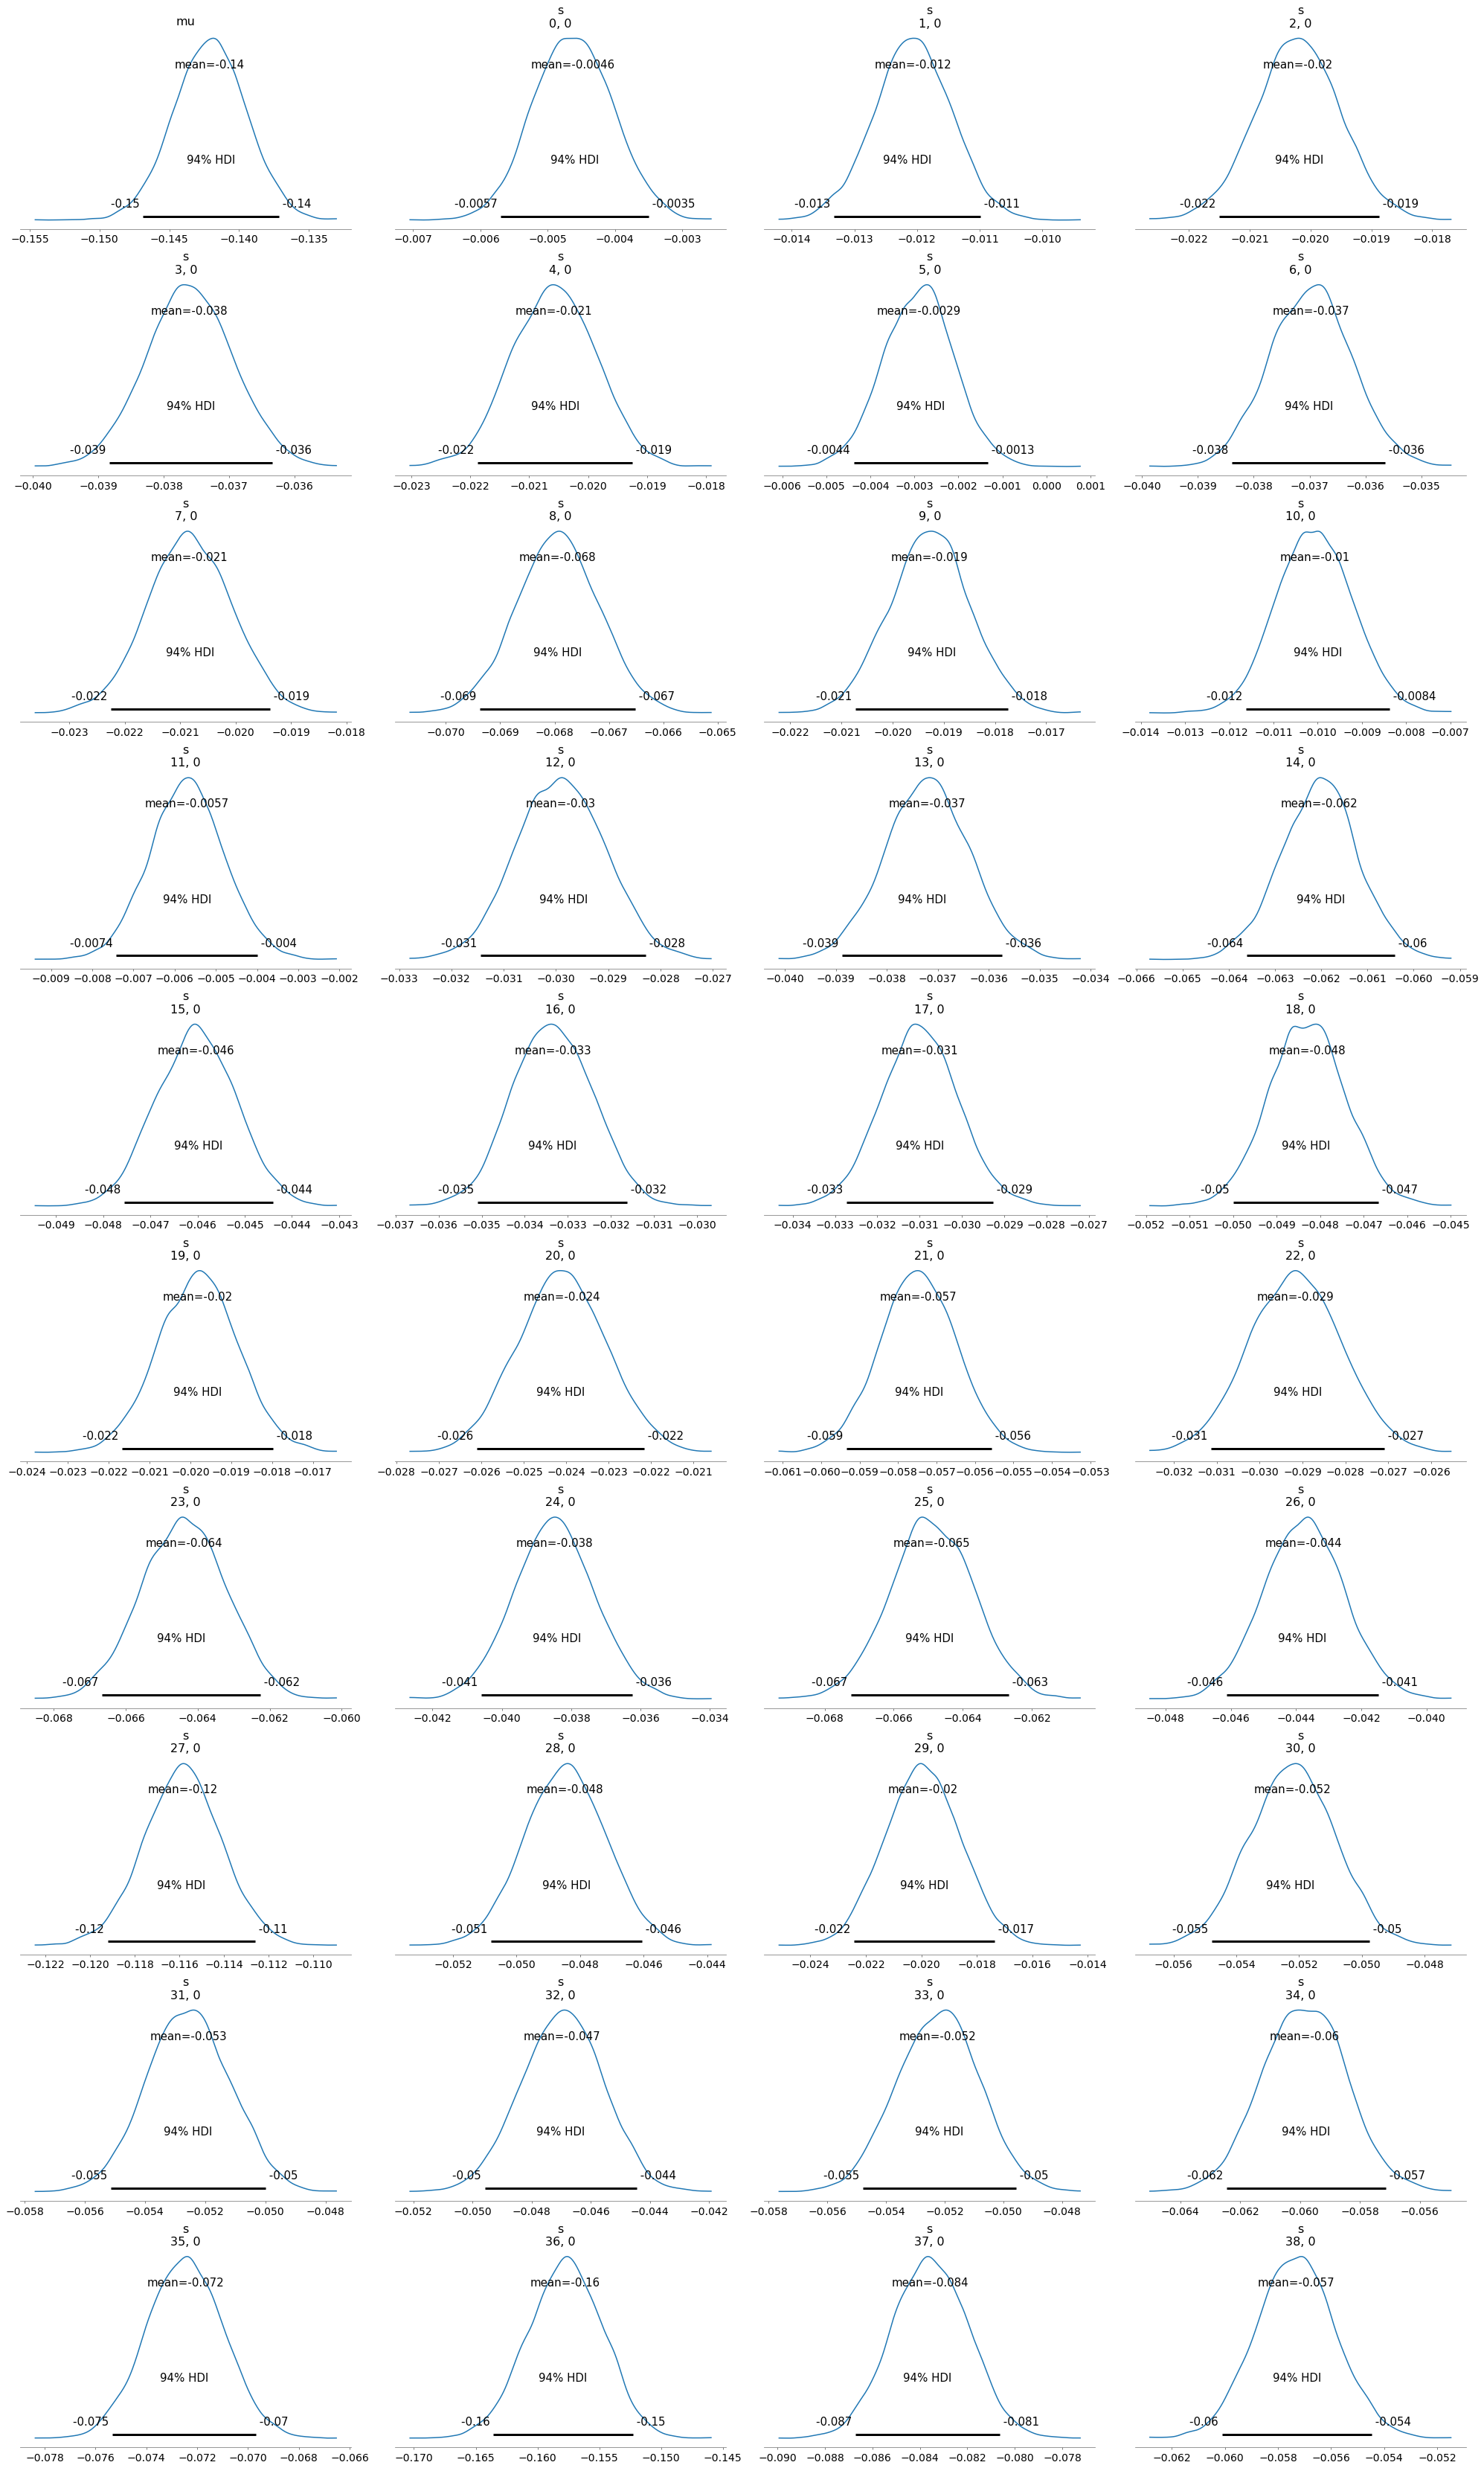

In [56]:
fitness_model.plot_mcmc_posterior()

The distribution of fitness values for real data.